<h1><center> Fraud Detection in E-Commerce Website Purchases </center></h1>

<figure>
  <center><img src="images/fraud_toon.png" width = "700"/>
      <figcaption><b>Fig.1</b> - Data Scientist reporting Anomalous Behavior </figcaption></center>
</figure>

<b>Author:</b> Nitya Mandyam <br>
<b>Contact:</b> nityamd@gmail.com <br>
<b>Last Modified:</b> 07/08/2019

<h2> Table of Contents:<a name="TOC"></a></h2>

- [0. Problem Statement](#Objective)
- [1. Exploratory Data Analysis ](#EDA)
- [2. Feature Selection](#FS)
    - [Signup/Purchase Times](#FS-SP)
    - [Lag Times](#FS-LT)
    - [Device Frequency](#FS-DF)
    - [Risk by Country](#FS-RC)
    - [The Rest](#FS-TR)
- [3. Feature Engineering](#FE)
    - [Preprocessing](#FE-PP)
    - [Correlation Matrix](#FE-CM)
    - [Train-Test Split](#FE-TTS)
- [4. Modeling](#modelling)
    - [Model 1: Logistic Regression with Balanced Class Weights](#model1)
    - [Model 1: Evaluation and Insights](#model1ei)
- [5. Conclusion](#Conclusion)
- [6. *Appendix*](#Appendix)
    - [Model 2: Random Forest Classifier with SMOTE](#model2)
    - [Model 2: Evaluation and Insights](#model2ei)

<h2>0. Problem Statement <a name="Objective"></a></h2>


The dataset explored here is from an E-Commerce website and contains information about first time users' transactions in the year 2015. The goal is to build a model that would predict fradulent transactions.<br>

Fraud in E-Commerce is a prevalent problem and there are various kinds of frauds including and not limited to: Card Not Present (CNP), where stolen/fake credit cards are employed, Return to Origin (RTO) fraud, wbere the store's refund policy is abused or the creation of multiple user accounts with a view to abuse promo codes. While I may not currently have the necessary domain expertise in this area to delve too deeply into the mechanisms of E-Commerce Fraud, it is worth noting the above as we do indeed come across some of these instances in this report. <br>

*Machine Learning* has been playing a useful and exciting role in detecting these fraudulent transactions where sophisticated algorithms are able to detect subtle patterns in the data that might escape the purview of manual analysis. Further, the amount of traffic in such platforms makes it critical to use fast, clear and interpretable techniques to parse and analyze these large amounts of data. <br>

The cannonical fraud/anomaly detection problem is an imbalanced data problem and our dataset here is no different. As shown below, out of a total **151112** purchases, the fraudulent ones constitute **~ 9.4%** of the data.<br>


<figure>
  <center><img src="images/class_imbalance.png" style="width: 300px;"/>
      <figcaption><b>Fig.2</b> - The Class Imbalance in the Data </figcaption></center>
</figure>


The consequence of this is that a [baseline](#baseline) model that predicts that every transaction is *not a fraud* has ~ 90.6% accurate! The confusion matrix chronicling this would look as follows (The code for this can be found in the Appendix).<br>

<figure>
  <center><img src="images/baseline_cm.png" style="width: 500px;"/>
      <figcaption><b>Fig.3</b> - The Confusion Matrix for a Baseline Model that predicts every transaction to be fraud-free. For such a model, the total accuracy, as defined by the ratio of true predictions to the total population would be ~ 0.906 or 90.6% here.  </figcaption></center>
</figure>

The above model fails in having any predictive power in terms of detecting fraud as both Precision and Recall for the Minority Class are zero here. There are two important takeaways from this. We need to use some technique to deal with the imbalanced class problem (typically, a method that either undersamples the majority class or oversamples the minority class). And we need to examine the precision and recall for the minority class along with looking at the accuracy of the model.<br>
Whether we choose to control for the false positives or false negatives (for the "fraud" class) here depends on the **cost** of the fraud. It might make sense to minimize the false positives (i.e., where the model does not predict a fraud where it should) if the business is most affected by the fraudulent transactions. On the other hand, the price of misclassifying a non-fraudulent transaction can be high too - companies routinely lose money and customers when fraud detectors predict "fraud" where there is none. While an ideal model would minimize both, it is worth keeping in mind that we might want to control for one or the other depending on what would give us the ***highest ROI*** from an economic standpoint.<br>


There are, thus, two important touchstones that a successful model should fulfill here: 
1. It is important to choose a modeling pipeline with high predictive power that effectively deals with the class imbalance. 

2. It is also equally important to have an **interpretable model** so that the client is ultimately presented with actionable insights on fraud prevention here. 

The latter involves careful feature selection and feature engineering and an enquiry into the most important and predictive features. Additionally, the business goals of the client would dictate the metrics to be controlled for via the tuning of the hyper-parameters such a model. 

<br>

<h2><center>1. Exploratory Data Analysis <a name="EDA"></center></a></h2>
<br>

<h3> A peek into the data </h3>

In [1]:

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import rcParams
import seaborn as sns
import sklearn
import os

#Notebook Preferences
import warnings
warnings.filterwarnings('ignore')

#Plotting preferences
rcParams["text.usetex"] = False
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
rcParams['font.size'] = 17
rcParams['axes.labelsize'] = 17
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20


colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

In [2]:
df = pd.read_csv("Fraud/Fraud_Data.csv")
print(len(df))
df.head()

151112


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


<h3> First Impressions: Class Imbalance and Non-unique Device ID's </h3>

Total counts by class
 0    136961
1     14151
Name: class, dtype: int64
Out of a total of 151112 purchases 9.364577267192546 % of them are fraudulent.


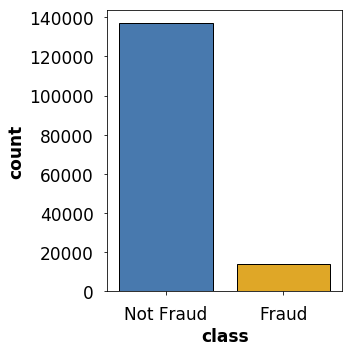

In [3]:
print('Total counts by class\n', df['class'].value_counts())
print('Out of a total of', len(df), 'purchases', 
      len(df[df['class']==1])*100/len(df), '% of them are fraudulent.')

fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(df['class'], ax=ax, edgecolor='black')
ax.set_xticklabels(['Not Fraud', 'Fraud'])
plt.tight_layout()
plt.savefig('images/class_imbalance.png')
plt.show();

The data is pretty imbalanced! Less than 10% of the transactions are fraudulent.

In [4]:
df.nunique()

user_id           151112
signup_time       151112
purchase_time     150679
purchase_value       122
device_id         137956
source                 3
browser                5
sex                    2
age                   58
ip_address        143512
class                  2
dtype: int64

There appear to be a few non-unique Device Id's while all the user_id's are unique, implying that there maybe multiple users for the same device. 


<h3> Checking for Missing Data </h3>

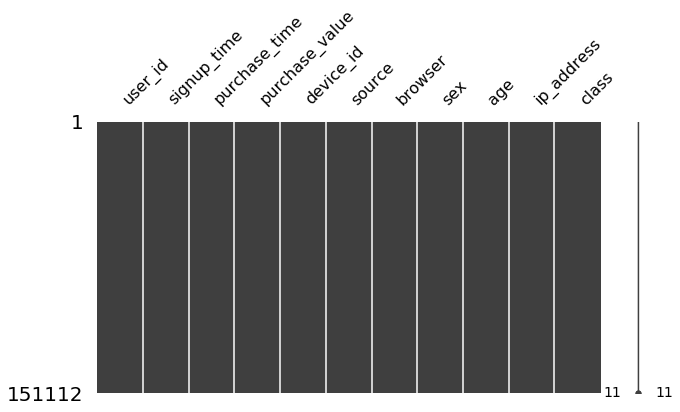

In [5]:
import missingno as msno
msno.matrix(df, figsize = (10,5));

No missing data, yay!  (Check out [https://github.com/ResidentMario/missingno](https://github.com/ResidentMario/missingno) for details on this very useful package.)

<h3> Ip Address Table and Merging it with the Fraud Data </h3>


In [6]:
country = pd.read_csv("Fraud/IpAddress_to_Country.csv")
print(len(country.country.unique()))
country.head()

235


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


I obtain the country for any IP Address in the data that falls within the upper and lower bounds as described by the above table. There are ~21000 entries whose IP addresses are not in the above the table - I impute them as "Unknown".

In [7]:
#Converting the IP Addresses to Floats
country.upper_bound_ip_address = country.upper_bound_ip_address.astype("float")
country.lower_bound_ip_address = country.lower_bound_ip_address.astype("float")
df.ip_address = df.ip_address.astype("float")

#Function to get country for IP Address
def get_country(ip):
    try :
        return country.country[(country.lower_bound_ip_address < ip)                            
                                & 
                                (country.upper_bound_ip_address > ip)].iloc[0]
    except IndexError:
        return "Unknown"

Adding a "Country" column to the fraud data and saving the DataFrame (so as to minimize runtime of the Notebook):

In [8]:
#Appending a country column

#df["country"] = df.ip_address.apply(get_country)
#df.to_csv("Fraud/fraud_with_country.csv")
#(takes a while to run!)

In [9]:
df = pd.read_csv("Fraud/fraud_with_country.csv", index_col = 0)
df.nunique()

user_id           151112
signup_time       151112
purchase_time     150679
purchase_value       122
device_id         137956
source                 3
browser                5
sex                    2
age                   58
ip_address        143512
class                  2
country              182
dtype: int64

<br>

<h2><center>2. Feature Selection <a name="FS"></a></center></h2>
<br>

I am going to go through each feature of the dataset systematically here to get some insight into important features before getting into the feature engineering and modeling.

<h3> A look at Signup/Purchase times <a name="FS-SP"></a> </h3>

In [10]:
#Converting the timestamps to date-time objects
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

In [11]:
#Calmap!!! To make pretty time series visualizations(https://pypi.org/project/calmap/)
import calmap

#Two time series data frames: one for purchase time and another for signup time.
ts_signup = df.set_index('signup_time')
ts_purchase = df.set_index('purchase_time')

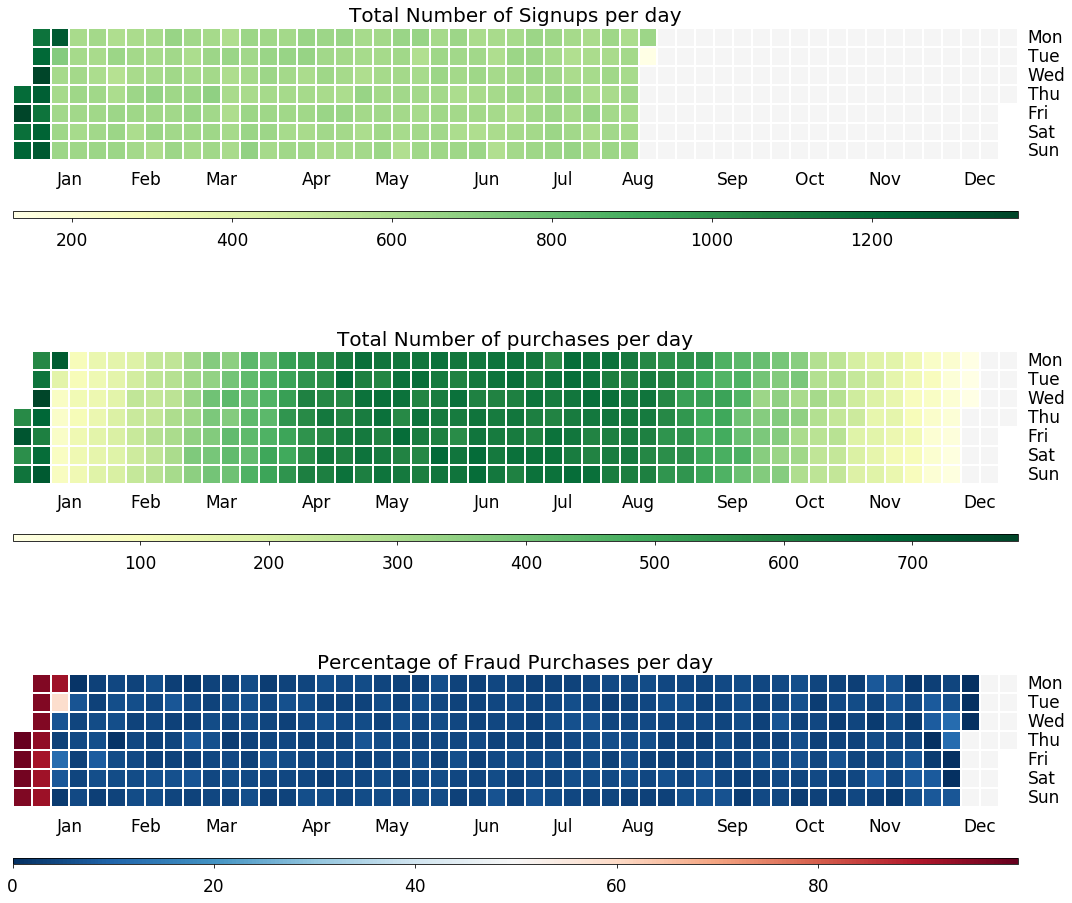

In [12]:
fig, (ax1,ax2, ax3) = plt.subplots(3,1,figsize = (15,14))

ax1.set_title('Total Number of Signups per day')
cax1 = calmap.yearplot(ts_signup['class'],how=u'count', cmap='YlGn', ax = ax1)
cbar1 = fig.colorbar(cax1.get_children()[1], ax=cax1, orientation='horizontal', aspect=150)

ax2.set_title('Total Number of purchases per day')
cax2 = calmap.yearplot(ts_purchase['class'],how=u'count', cmap='YlGn', ax = ax2)
cbar2 = fig.colorbar(cax2.get_children()[1], ax=cax2, orientation='horizontal', aspect=150)

ax3.set_title('Percentage of Fraud Purchases per day')
cax3 = calmap.yearplot(ts_purchase['class']*100,how=u'mean', cmap='RdBu_r', ax = ax3)
cbar3 = fig.colorbar(cax3.get_children()[1], ax=cax3, orientation='horizontal', aspect=150)

plt.gcf().subplots_adjust(top = 0.8, hspace = 0)
plt.tight_layout()
plt.savefig('images/calendar_plots.png')
plt.show()


Some observations about the first two weeks of the year:

1. There were a lot of signups in the first two weeks of the year!
2. And a lot of purchases the *exact* same weeks!
3. And most of them were **frauds**!

Natural follow-up questions would be: 

1. What is the distribution of the time lags between signup and purchase?
2. How are these "lag times" distributed across fraud vs not-fraud?

<h3> A look at Lag times <a name="FS-LT"></a> </h3>

In [13]:
#Calculating lag time, i.e, the lag between signup and purchase
df['lag_time'] = df['purchase_time'] - df['signup_time']
df['lagdays'] = df['lag_time'].dt.days
df['lagsecs'] = df['lag_time'].dt.total_seconds()
df['lagmilli'] = df['lag_time'].astype(np.int64)/int(1e6)
print(df.lag_time.min(), df.lagmilli.min())

0 days 00:00:01 1000.0


The least lag time between signup and purchase seems to be 1 second (or a thousand milliseconds, for a resolution check). It seems a bit absurd to presume that any human would make a purchase within a second of signup leading one to hypothesize that such transactions seem **suspicious**! <br>

I thus looked at the distribution of lag times across the two classes:

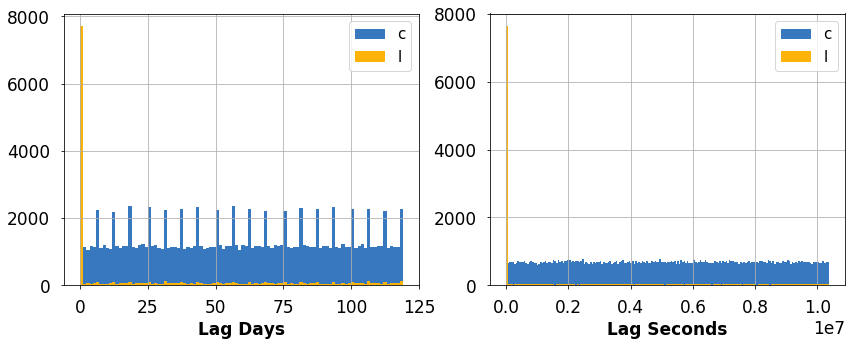

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (14,5))
df.groupby('class')['lagdays'].hist(ax=ax1, bins = 100)
ax1.legend('class', loc = 0)
ax1.set_xlabel('Lag Days')
df.groupby('class')['lagsecs'].hist(ax=ax2, bins = 200)
ax2.legend('class')
ax2.set_xlabel('Lag Seconds')
plt.savefig('images/Lagtime_distributions.png');
plt.show()

In [15]:
df.query('lagmilli == 1000').groupby('class')['user_id'].count()

class
1    7600
Name: user_id, dtype: int64

And indeed, **all** 7600 transactions that took exactly 1000 milliseconds are fraudulent!

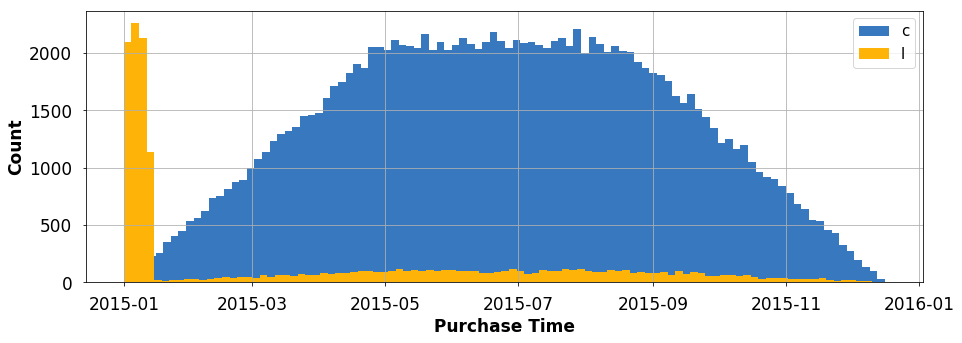

In [16]:
fig, ax = plt.subplots(figsize = (15,5))
df.groupby('class')['purchase_time'].hist(ax=ax, bins = 100)
ax.legend('class')
plt.ylabel('Count')
plt.xlabel('Purchase Time');
plt.show()

Looking at the counts as per purchase time, the feature we saw earlier in the calendar plots, all of these 7600 transactions (about half the total number of frauds in the dataset) occured within the first two weeks of the year. <br>

**Food for thought**: Was this an attempt at exploiting possible New Year deals available at the platform?

<h3> Investigating Device Frequency <a name="FS-DF"></a> </h3>

In [17]:
num_duplicates = pd.DataFrame(df.duplicated(subset = "device_id")).mean()
print(num_duplicates*100)

0    8.706125
dtype: float64


About 8.7% of the devices have multiple user_id's! Considering this dataset consists of only first transactions, it definitely is odd that the same device should have multiple user_id's!<br>

I introduce a new variable, "freqdevice", which captures this as the frequency of the device used in the dataset. I then look at the distribution of "freqdevice" across the classes.

In [18]:
dup_df = pd.DataFrame(df.groupby(by = "device_id").device_id.count())  
dup_df.rename(columns={"device_id": "freqdevice"}, inplace=True)    
dup_df.reset_index(level=0, inplace= True)

In [19]:
# finally we merge with dataset
df = df.merge(dup_df, on= "device_id")

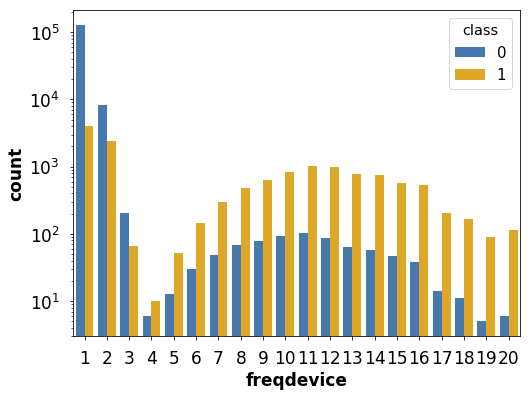

In [20]:
fig,ax = plt.subplots( figsize = (8,6))
sns.countplot(x = 'freqdevice',hue = 'class', data = df, ax = ax);
plt.yscale('log');
plt.show()

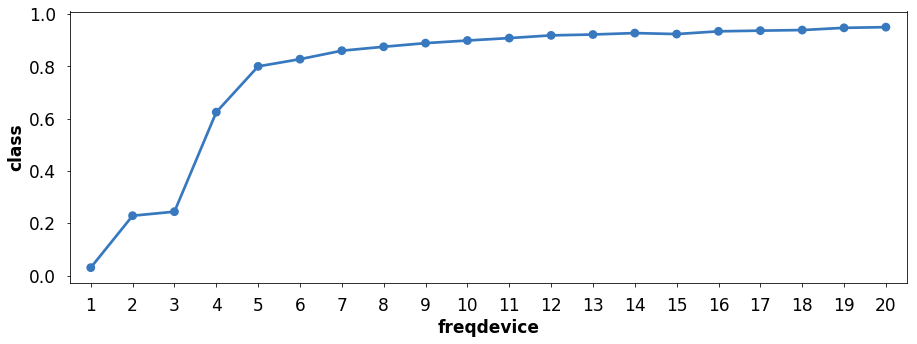

In [21]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(x = "freqdevice", y= "class", data = df, logistic=True, ci=None, ax =ax);
plt.show()

It definitely seems to be the case that the fraud percentages increase significantly with increase in device frequency. This captures what was referred to in the [Problem Statement](#Objective) - the type of fraud where multiple user accounts are created with a view to possibly exploit coupons/promo codes.<br>

<h3> Fraud Distributions by Country<a name="FS-RC"></a> </h3>

In [22]:
#Looking at the fraud percentage by country (country_fraud: cf)
country_fraud = pd.DataFrame(df.groupby(by="country").mean()["class"].sort_values(ascending = False))
country_fraud.head()

,class
country,
Turkmenistan,1.000000
Namibia,0.434783
Sri Lanka,0.419355
Luxembourg,0.388889
Virgin Islands (U.S.),0.333333


Some countries like Turkmenistan and Namibia have a fraud rate that greatly exceeds the average fraud rate across countries. A deeper look shows that Turkmenistan and Namibia have only a few transactions at all. We will however use the disparity in country transactions as a feature in our models below without particularly singling out these one off cases.<br>

In [23]:
country_fraud_counts = pd.DataFrame(df.groupby(by="country").count()["class"].sort_values(ascending = False))
country_fraud_counts.head(10)

,class
country,
United States,58049
Unknown,21966
China,12038
Japan,7306
United Kingdom,4490
Korea Republic of,4162
Germany,3646
France,3161
Canada,2975


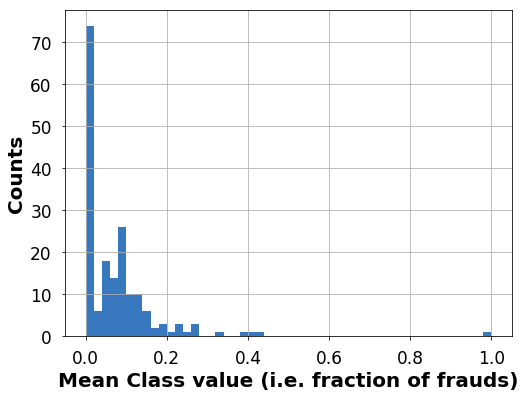

In [24]:
fig,ax = plt.subplots( figsize = (8,6))
country_fraud['class'].hist(bins = 50, ax = ax)
plt.ylabel('Counts', fontsize = 20)
plt.xlabel('Mean Class value (i.e. fraction of frauds)', fontsize = 20);
plt.show()

We will exploit this distribution in the [Feature Engineering](#FE) section to assign a "risk score" to each country.

<h3> The Rest: The categorical Variables (Source, Browser and Sex), Age and Purchase Value<a name="FS-TR"></a> </h3>
<br>

A quick look at the mean class value (i.e., fraction of frauds) between the different sources, browsers and sex of the users.

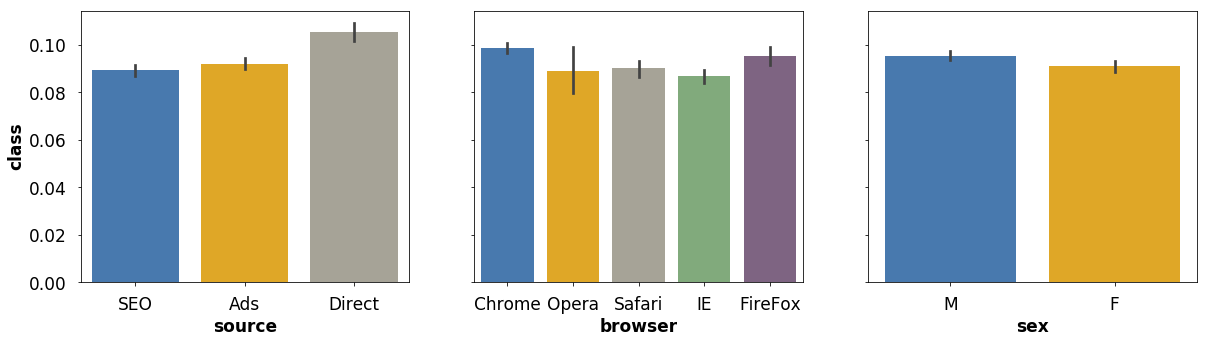

In [25]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,5), sharey = True)

sns.barplot(x = 'source', y = 'class', ax = ax1,  data = df);
sns.barplot(x = 'browser', y = 'class', ax = ax2, data = df);
sns.barplot(x = 'sex', y = 'class', ax = ax3, data = df);

ax2.set_ylabel('')    
ax3.set_ylabel('')
plt.show()

Among Sources, Direct seems to have marginally higher fraction of frauds. Among browsers, Chrome and Firefox seem to have a higher fraction of frauds. And finally, among the sexes, males seem to have a slightly higher mean class value. None of this seems particularly significant in relation to the other features discussed thusfar. <br>

The purchase values and ages, as plotted below do not have seem to have distinguishably different distributions across the classes. <br>

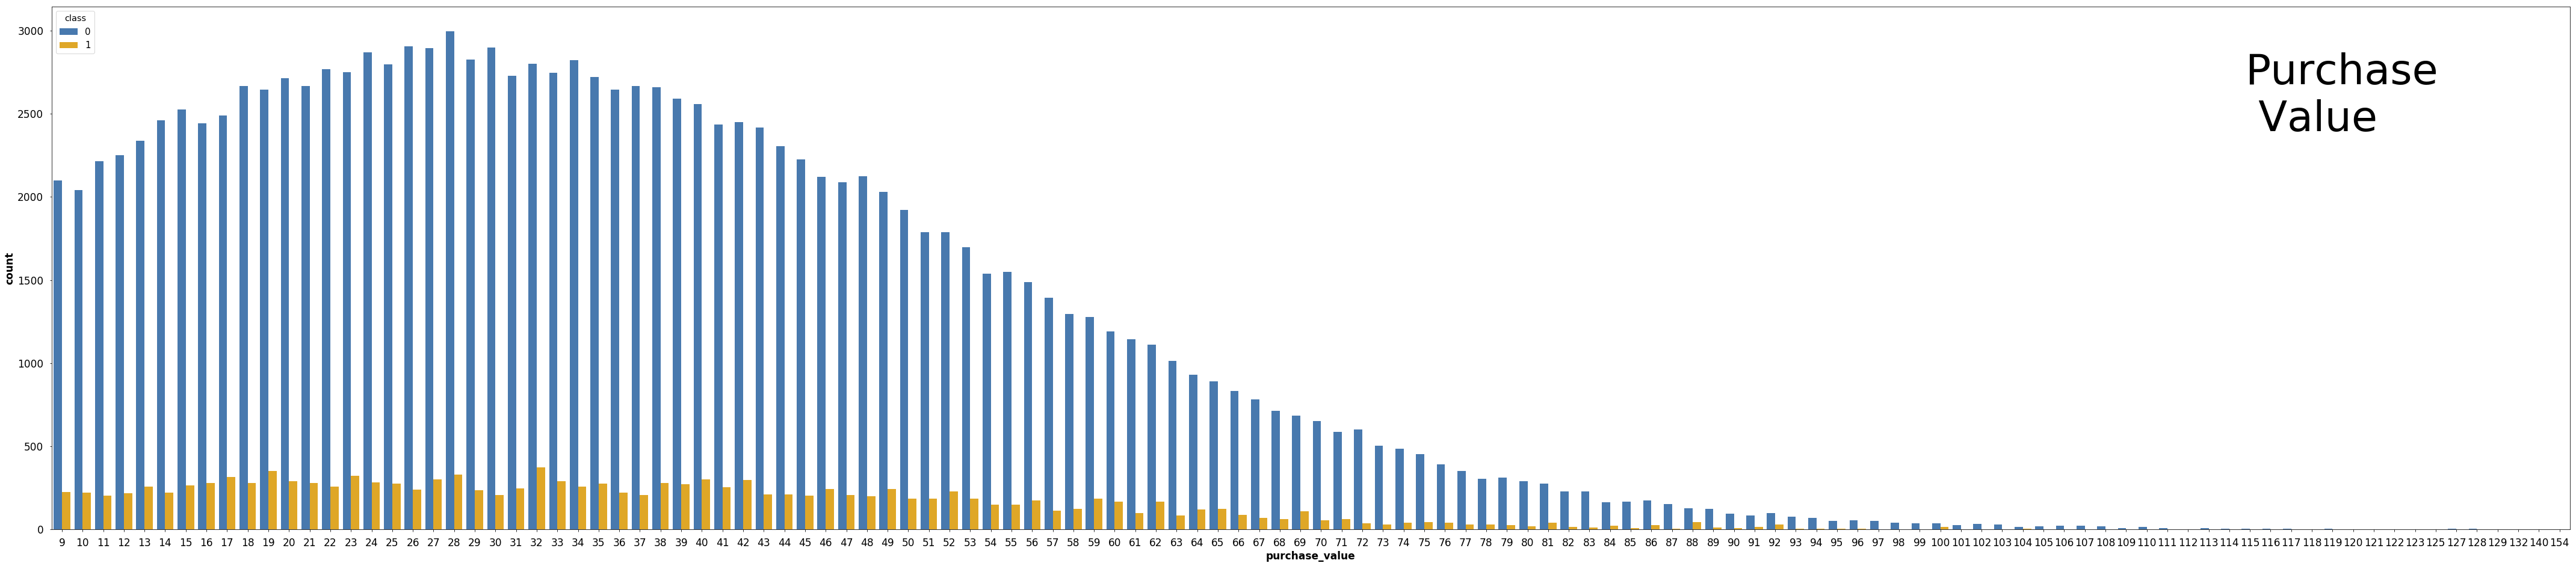

In [26]:
fig,ax = plt.subplots( figsize = (75,16))
sns.countplot(x = 'purchase_value',hue = 'class', data = df, ax = ax)
fig.text(0.8,0.7,'Purchase\n Value', fontsize = 70)
plt.show()

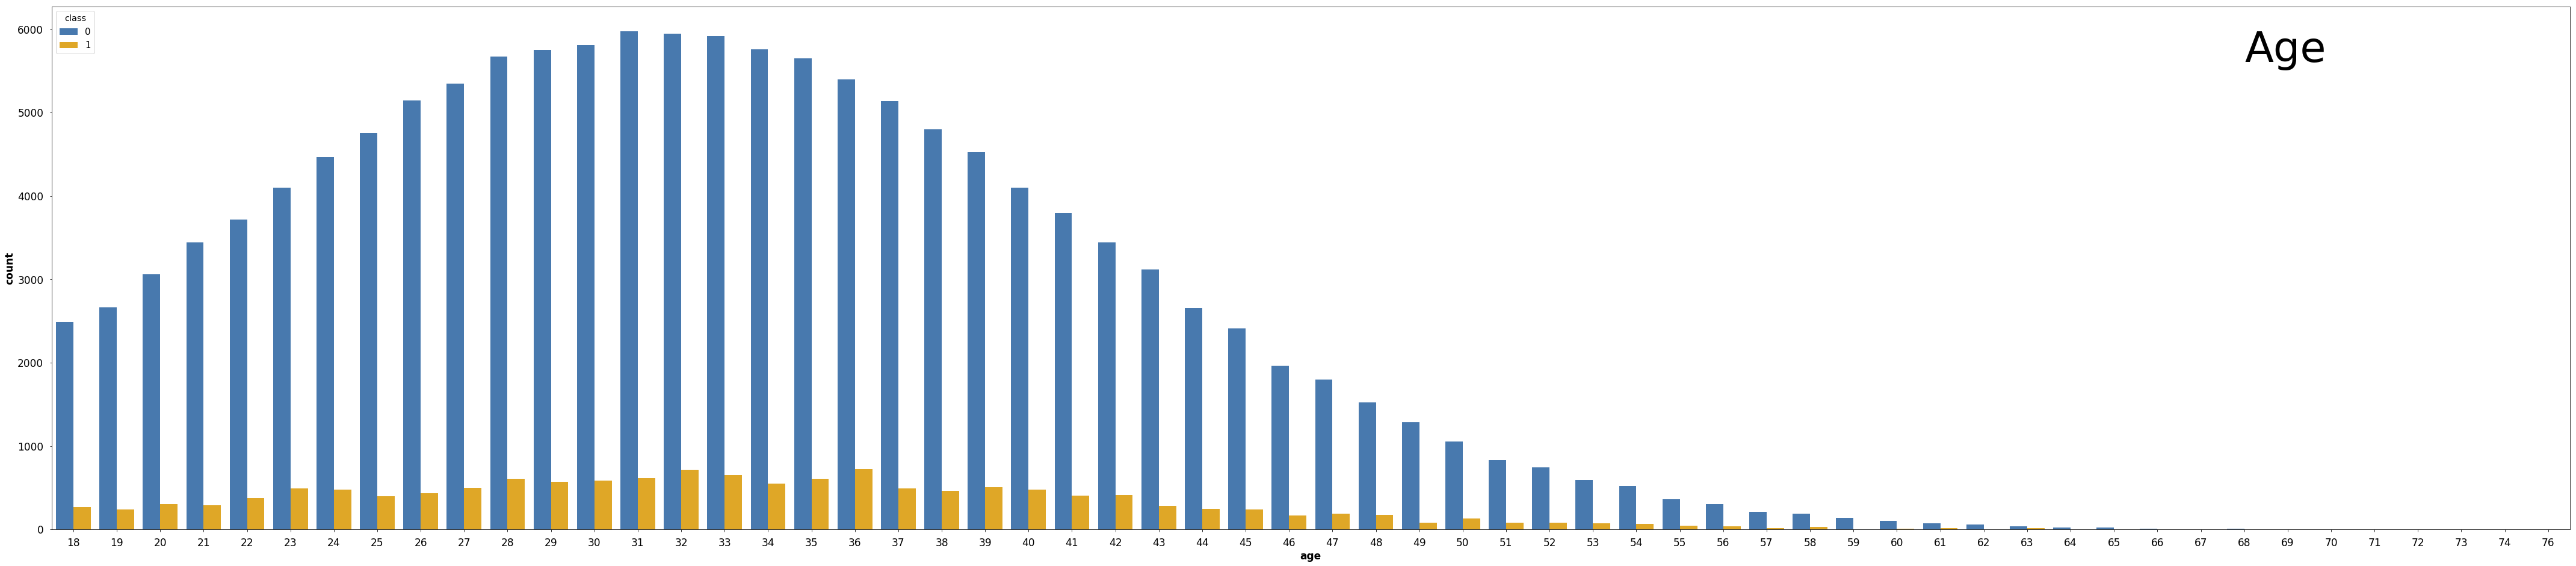

In [27]:
fig,ax = plt.subplots( figsize = (75,16))
sns.countplot(x = 'age',hue = 'class', data = df, ax = ax)
fig.text(0.8,0.8,'Age', fontsize = 70)
plt.show()

<br>

<h2><center> 3. Feature Engineering <a name="FE"></a></center></h2>
<br>

<h3> Feature Space Description and Preprocessing <a name="FE-PP"></a> </h3>

The features (and transformations of features) we're going to use are listed below. It is in descending order of (guessed/presumed) importance as gleaned from the exploration done above.<br>

1. Time Related:
    - Lag time: Time between Signup and Purchase (In total seconds.)
    - Immediate_Purchase:  1 if it is "flash transaction" (i.e., one that happens with a lag time of exaclty one second) and 0 if it isn't
2. Device Frequency: Number of user_id's per device, as discussed in the previous section.
3. Country Risk: We're going to assign a "risk score" based on the distibution of the fraction of frauds.
4. Categoricals: One-hot encoding the categorial variables such as Source, Browser and Sex. (This is quite a reasonable idea here because the number of features in this problem isn't too big.)
5. Purchase Value and Age: I'm keep Purchase Values and Ages as they are
6. Columns that will be dropped: user_id, signup_time, purchase_time, device_id, source, browser, sex, ip_address, country, lag_time, lagdays, lagmilli.
<br>

Following is an implementation of these 6 steps:

In [28]:
#1. Getting Immediate_Purchases
df["immediate_purchase"] = df["lagsecs"].apply(lambda x : 1 if x == 1 else 0)

In [29]:
#2. Device Frequency: Already done!
#3. Country Risk: Assigning risk scores according to the fraud percentages
country_fraud["risk_score"] = country_fraud["class"].apply(lambda x : 
                                                           3 if x > 0.3 else
                                                           2 if x > 0.05 else
                                                           1 if x > 0.01 else
                                                           0)
df = df.merge(country_fraud.drop("class", axis = 1), left_on= "country", right_index = True)

In [30]:
#4. Categoricals: One-hot encoding everything:
sex = pd.get_dummies(df['sex'], prefix = 'sex')
df = pd.concat([df, sex.iloc[:, :2]], axis=1)

source = pd.get_dummies(df['source'], prefix = 'source')
df = pd.concat([df, source.iloc[:, :3]], axis=1)

browser = pd.get_dummies(df['browser'], prefix = 'browser')
df = pd.concat([df, browser.iloc[:, :3]], axis=1)

In [31]:
#5. Purchase Value: Nothing to do here!
#6. Drop Columns:
df = df.drop(columns = ['user_id', 'signup_time', 'purchase_time', 
                        'device_id', 'source', 'browser', 'sex', 
                        'ip_address', 'country', 'lag_time', 
                        'lagdays', 'lagmilli'])

In [32]:
#Writing it to a csv so we don't have to repeat all of the above! :)
df.to_csv('Fraud/features.csv')

<h3> Correlation Matrix <a name="FE-CM"></a></h3>

A quick look at the Feature Space and the Correlations between the features:

In [33]:
df = pd.read_csv('Fraud/features.csv', index_col = 0)
df.head()

,purchase_value,age,class,lagsecs,freqdevice,immediate_purchase,risk_score,sex_F,sex_M,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE
0,34,39,0,4506682.0,1,0,2,0,1,0,0,1,1,0,0
61,72,32,0,5959702.0,1,0,2,1,0,0,1,0,1,0,0
70,52,44,0,662649.0,1,0,2,1,0,0,1,0,1,0,0
84,67,49,0,82537.0,2,0,2,1,0,0,1,0,0,0,1
91,33,34,0,5951052.0,2,0,2,1,0,0,0,1,1,0,0


In [34]:
len(df), df.columns

(151112, Index(['purchase_value', 'age', 'class', 'lagsecs', 'freqdevice',
        'immediate_purchase', 'risk_score', 'sex_F', 'sex_M', 'source_Ads',
        'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox',
        'browser_IE'],
       dtype='object'))

In [35]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

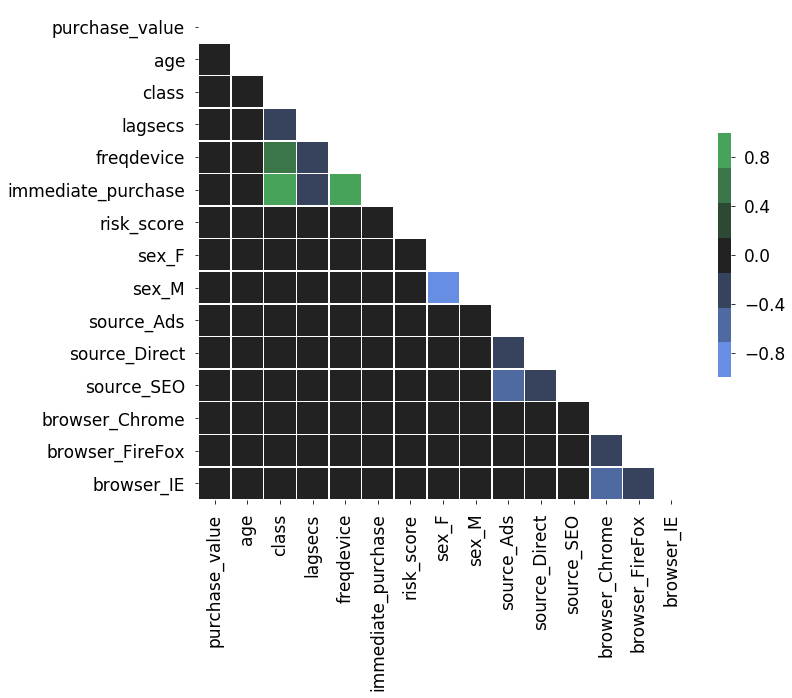

In [36]:
corr = df.corr()
cmap = sns.diverging_palette(255, 133, l=60, n=7, center="dark")

f, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,cmap = cmap, vmin = -1,vmax=1, center=0, mask = mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.savefig('images/Feature_Correlations.png')
plt.show()

There are a few obvious correlations and anti-correlations here: M and F are anti-correlated. The 3 sources are anti-correlated with each other. And the 3 browsers are anti-correlated with each other as well.<br>

Bases on our analysis in Section [3](#FS), we can see that the Class is highly correlated with Device frequency and with Immediate_Purchase and a little less strongly anti-correlated with Lagseconds.<br>

However, both the device frequency and the indicator of the flash transaction are strongly correlated with each other, suggesting that these might be clustered similarly.<br>

The correlations (and anti-correlations) of Class with the rest of the variables are significantly small, but the right model should be able to rank the feature importances appropriately - thus, I'm going to keep them all for now. There are thus **14 features** in total. <b>

<h3> Train-Test Split <a name="FE-TTS"></a></h3>

Before we go further with the modeling, it's important to randomly break up the dataset into train and test. I'm doing an 80-20 split.<br>
(It would be interesting to go even further and do a 70-20-10 train-test-validation split but I'm sticking to the simpler version for now and hope to use some form of resampling or cross-validation technique later on.)

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X = df.drop(columns = ['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 43, test_size=0.2)

In [39]:
#K-fold Cross-validation: Stratified Split

<br>

<h2><center> 4. Modeling <a name="modelling"></a></center></h2>
<br>

As has been alluded to in the [Problem Statement](#Objective), we would like to use either an undersampling or oversampling technique to deal with the problem of class imbalance. Because it is a binary classification problem, the two natural choices here would be Logistic Regression and a Decision Tree of sort. Since undersampling usually is a riskier venture in terms of missing out on precious data, for my first model, I choose a Logistic Regression with Balanced Class Weights and for my second model, I build a pipeline with SMOTE, a popular oversampling technique. <br>

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, \
                            recall_score, classification_report, confusion_matrix, \
                            log_loss, roc_curve, auc, precision_recall_curve, average_precision_score

<h3> Model 1: Logistic Regression With Balanced Class Weights <a name="model1"></a></center</h3>

Scikit-Learn's Logistic Regression module allows us an option of balancing class weights. It does so by automatically weighing the classes inversely proportional to their frequency of occurence in the dataset.

In [41]:
lr = LogisticRegression(solver = 'newton-cg', class_weight = 'balanced', max_iter = 4000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred));

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     27362
           1       0.79      0.60      0.68      2861

   micro avg       0.95      0.95      0.95     30223
   macro avg       0.87      0.79      0.83     30223
weighted avg       0.94      0.95      0.94     30223

[[26903   459]
 [ 1146  1715]]


<h3> Model 1: Evaluation and Insights <a name="model1ei"></a></center </h3>

In [42]:
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
average_precision = average_precision_score(y_test, lr.predict_proba(X_test)[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, lr.predict_proba(X_test)[:,1])
pr_auc = auc(recall, precision)


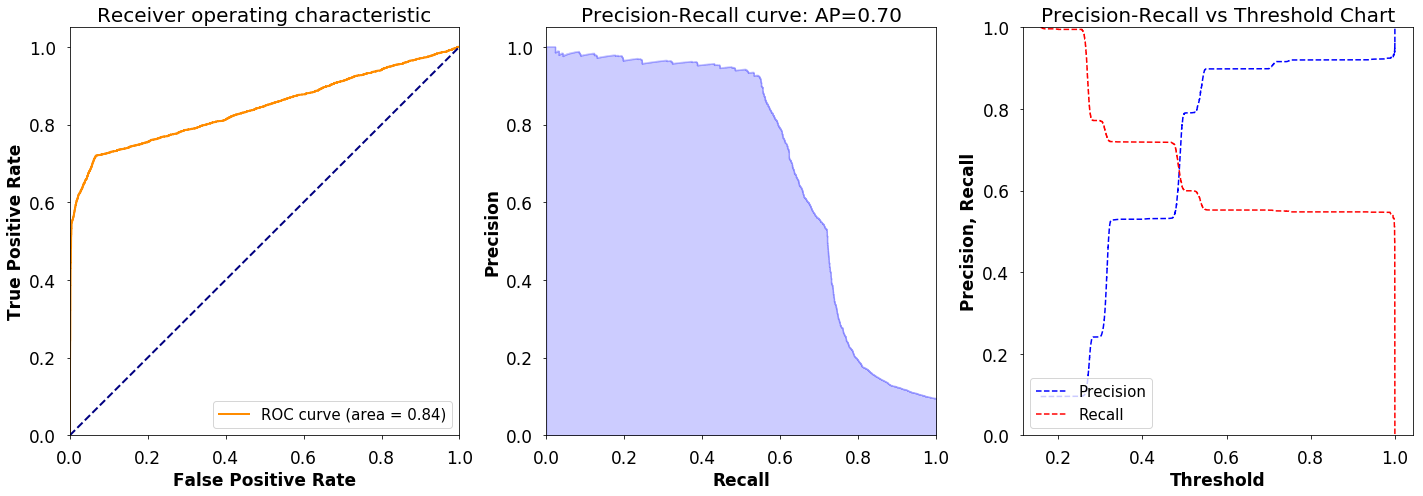

In [43]:
from inspect import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters

               else {})
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(20,7))

ax1.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver operating characteristic')
ax1.legend(loc="lower right")

ax2.step(recall, precision, color='b', alpha=0.2,
         where='post')
ax2.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_ylim([0.0, 1.05])
ax2.set_xlim([0.0, 1.0])
ax2.set_title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

ax3.set_title("Precision-Recall vs Threshold Chart")
ax3.plot(thresholds, precision[: -1], "b--", label="Precision")
ax3.plot(thresholds, recall[: -1], "r--", label="Recall")
ax3.set_ylabel("Precision, Recall")
ax3.set_xlabel("Threshold")
ax3.legend(loc="lower left")
ax3.set_ylim([0,1])

plt.tight_layout()
plt.savefig('images/logreg_curves.png')
plt.show()

The plot to the left demonstrates that the logistic regression model has some success at detecting fraudulent transactions as the ROC curve has a sizeable AUC. The second and third plots depict how the threshold in my logistic regression model produces a trade-off between precision and recall. In fact, a threshold hold of approximately 0.5 will produce an even performance for precision and recall at about ~60% each.<br>

We're already at an optimal threshold to have a reasonable value for both. We can adjust the thresholding depending on whether we would like to control for the False Positives or False Negatives - and this would be dictated by the needs of the client. <br>

In other words, we cannot really determine a best threshold until we know the costs associated with a falsely identified fraudulent charge and the losses associated with a real fraudulent charge.<br>

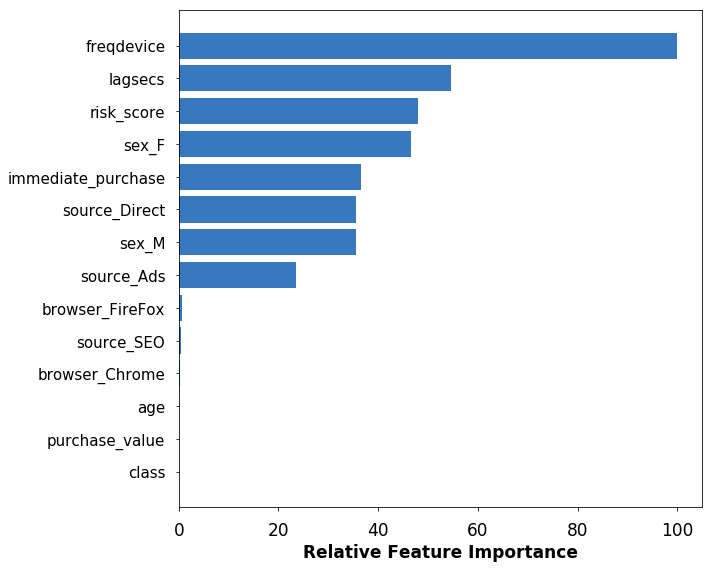

In [44]:
feature_importance = abs(lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize = (10,8))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(df.columns)[sorted_idx], fontsize=15)
featax.set_xlabel('Relative Feature Importance')
#plt.title('isbuyer=0')
plt.tight_layout()
plt.savefig('images/logreg_feature_importance.png')
plt.show()

This is in line with our expectations! We **DO** expect device frequency and lagsecs (or immediate_purchase) to be the key predictive features. The thir place here, in terms of feature importance is the risk score associated with the country and this gives us an interesting piece of information to examine. Its importance in Model 2 has been demoted and it would need further investigation to be able to conclusively assign its importance. <br>

<h5> An aside on modeling: </h5>

Because of the very high correlation between the 1s transactions, the device frequency and fraud, it would be interesting to classify the frauds as "blatant" vs "not-blatant". This would mean having a pipeline where the flash transactions are classified first and then building a model for the rest of the purchases which at a cursory glance seem to have a similar distribution to the non-fraud data. This would possibly entail the following: exploring that part of the parameter space exhaustively using a method such as Grid Search and/or using a gradient descent technique to iteratively re-weight the features and tune the hyperparameters accordingly. <br>

<br>

<h2><center>5. Conclusion and Actionable Insights <a name="Conclusion"></a></center></h2>
<br>



Catching fraudulent purchases before sales are finalized can save a company from a great deal in losses. In this initial exploration, I made several statistical insights before creating and evaluating two models for detecting fraud. I have summarized my key findings and insights here. <br>


<h5> Insights from Feature Selection and Engineering </h5>

Exploring the individual features provided and constructing a few of our own let to a number of key insights:
1. Fraudulent charges are a severe minority class- this is an anomaly detection problem.
2. The lag time between signing up time and purchase time can identify nearly half of the all the frauds from 2015.
3. Many of the fraudulent purchases took place near the new year.
4. The number of times a device is used to make purchases is positively correlated with those purchases being fraudulent.
5. Users who list themselves as being from certain countries is also positively correlated with fraudulent transactions.

Using boosting techniques such as XGBoost or AdaBoost could definitely up the predictive power of the models. However, it requires careful examination in terms of interpretation and I have laid down the groundwork here in terms of feature engineering and computationally fast and interpretable modeling to take this next step. 

<h5> On Deploying the Models </h5>

To put either of these models in production, I would first have to consider how the data are delivered to me. If the data are stored in an S3 bucket for instance, I could configure AWS Lambda to be triggered by the addition of data and instantly run the new data through either model. If the data most be processed in real-time I could imagine using Amazon SageMaker to perform real-time predictions with an inference pipeline.

<h5> Actionable Insights </h5>

- It would seem obvious that the client should flag all transaction that take place one second after sign up as fraudulent, however, they may have a reason for not flagging such transactions. I would suggest broaching this subject without being paternalistic.

- Since this dataset is limited to first transactions alone, it would be interesting to look at the behavior of repeating customers as it may help in identifying anomalous behavior better.

- Data across the years could help conclusively determine whether the "Case of the January Flash Transaction Fraud Epidemic" is an isolated occurrence or not. Further, there would be the exciting possibility of doing time series analysis to better understand the "seasonal trends" in E-Commerce Fraud.

- Finally, to understand the needs of the client here would be extremely valuable. Is their fraud detection software catching too many False Positives? Or is the opposite scenario? The goals of modeling could be significantly different in either case.

<h1><center> Thanks for reading!! </center></h1>

<br>

<big>[*Appendix*](#Appendix):</big> <br>
- Model 2: the Random Forest Classifier with SMOTE 
- The baseline model

<h3>Model 2: Random Forest Classifier with SMOTE <a name="model2"></a></center </h3>

One can imagine a decision tree being very suited to this problem in particular as there are key important features that the nodes can be split on.

In [45]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)
print(classification_report(y_test, y_pred_dtc))
print(confusion_matrix(y_test, y_pred_dtc));

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     27362
           1       0.54      0.60      0.57      2861

   micro avg       0.91      0.91      0.91     30223
   macro avg       0.75      0.77      0.76     30223
weighted avg       0.92      0.91      0.92     30223

[[25910  1452]
 [ 1144  1717]]


As decision trees are prone to overfitting, we would like to try a random forest classifier instead.

In [46]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf));

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     27362
           1       0.91      0.56      0.69      2861

   micro avg       0.95      0.95      0.95     30223
   macro avg       0.93      0.78      0.83     30223
weighted avg       0.95      0.95      0.95     30223

[[27203   159]
 [ 1260  1601]]


However we have still not dealt with the imbalanced class issue here. SMOTE or Synthetic Minority Oversampling Technique is a way of generating synthetic data for the minority class using K-nearest neighbors analysis. It is essential that we "SMOTE" on the *training* set after the train-test split and then evaluate the metrics on the test set.

In [47]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, ratio = 0.7)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
# Train a logistic regression model on the upsampled training data.
sm_rfc = RandomForestClassifier()
sm_rfc.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
y_pred_smrfc = sm_rfc.predict(X_test)
print(classification_report(y_test, y_pred_smrfc))
print(confusion_matrix(y_test, y_pred_smrfc))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     27362
           1       0.90      0.56      0.69      2861

   micro avg       0.95      0.95      0.95     30223
   macro avg       0.93      0.78      0.83     30223
weighted avg       0.95      0.95      0.95     30223

[[27180   182]
 [ 1245  1616]]


<h3> Model 2: Evaluation and Insights <a name="model2ei"></a></center</h3>

<h5> Feature Importances </h5>

In [49]:
importances = sm_rfc.feature_importances_

In [50]:
std = np.std([tree.feature_importances_ for tree in sm_rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], X.columns[indices[f]]))

Feature ranking:
1. feature 3 (0.408456) freqdevice
2. feature 2 (0.121653) lagsecs
3. feature 4 (0.120884) immediate_purchase
4. feature 11 (0.057979) browser_Chrome
5. feature 9 (0.048669) source_Direct
6. feature 10 (0.042000) source_SEO
7. feature 8 (0.039297) source_Ads
8. feature 0 (0.033377) purchase_value
9. feature 6 (0.033350) sex_F
10. feature 1 (0.029142) age
11. feature 13 (0.025716) browser_IE
12. feature 7 (0.023603) sex_M
13. feature 12 (0.014846) browser_FireFox
14. feature 5 (0.001027) risk_score


**The top 2 features are in agreement with Model 1!!!**

The noteworthy difference as opposed to Model 1 in terms of feature importance would be that the risk associated with "Country" has been demoted here.

However the model is not (*yet*) doing significantly better than the Logistic Regression model. With appropriate hyper-parameter tuning and setting the right SMOTE ratio by making use of grid search would enable us to improve the predictive power of this pipeline. <br>

To circle back to our original confusion matrix though, it is worth looking at the performance of this model on the dataset as a whole.

In [51]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.copper):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.tight_layout()

    return plt

<h5>Performance on the whole dataset </h5>

In [52]:
df_pred_smfrc = sm_rfc.predict(X)

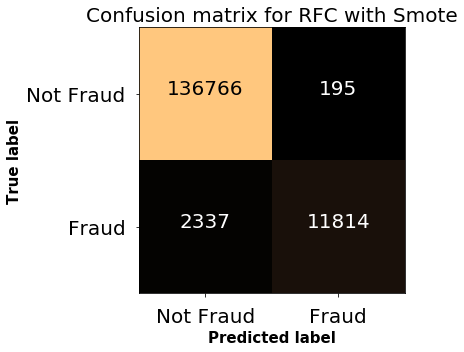

[[136766    195]
 [  2337  11814]]


In [53]:
cm = confusion_matrix(y, df_pred_smfrc)
fig = plt.figure(figsize=(7, 5))
plot = plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'], normalize=False, title='Confusion matrix for RFC with Smote')
plt.savefig('images/rfc_cm.png')
plt.show()
print(cm)

<h3>Baseline Model <a name="baseline"> </h3>

In [54]:
def baseline_model(df):
    no_fraud = np.zeros(len(df))
    return no_fraud

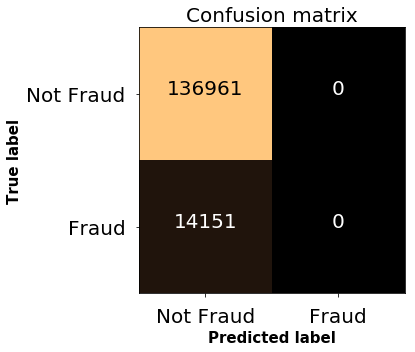

[[136961      0]
 [ 14151      0]]


In [55]:
y_pred = baseline_model(df)
cm = confusion_matrix(df['class'], y_pred)
fig = plt.figure(figsize=(7, 5))
plot = plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'], normalize=False, title='Confusion matrix')
plt.savefig('images/baseline_cm.png')
plt.show()
print(cm)